In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import histlite as hl
import csky as cy

%matplotlib inline
mpl.style.use('/home/apizzuto/Nova/python3/scripts/novae_plots.mplstyle')

In [2]:
timer = cy.timing.Timer()
time = timer.time

In [3]:
with time('ana setup (from scratch)'):
    ana = cy.get_analysis(cy.selections.mrichman_repo, cy.selections.MESEDataSpecs.mesc_7yr_dnn)

Setting up Analysis for:
MESC_2010_2016_DNN
Setting up MESC_2010_2016_DNN...
Reading /data/user/mrichman/data/analyses/mese/current/mese_cascades_MC_2013_dnn.npy ...
Reading /data/user/mrichman/data/analyses/mese/current/mese_cascades_2010_2016_dnn.npy ...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.

0:00:10.506147 elapsed.


In [4]:
ana_dir = cy.utils.ensure_dir('./ana')
ana.save(ana_dir)

-> ./ana/MESC_2010_2016_DNN.subanalysis.npy    


In [5]:
with time('ana setup (from cache-to-disk)'):
    ana = cy.get_analysis(cy.selections.mrichman_repo, cy.selections.MESEDataSpecs.mesc_7yr_dnn, dir=ana_dir)

Setting up Analysis for:
MESC_2010_2016_DNN
Setting up MESC_2010_2016_DNN...
<- ./ana/MESC_2010_2016_DNN.subanalysis.npy    
Done.

0:00:00.576564 elapsed.


In [6]:
cy.CONF['ana'] = ana
cy.CONF['mp_cpus'] = 5

In [7]:
src = cy.sources(271.23, 7.78, deg=True)
#src = cy.sources(0.0, 0.0, deg=True)
tr = cy.get_trial_runner(src=src)

In [8]:
with time('ps bg trials'):
    n_trials = 10000
    bg = cy.dists.Chi2TSD(tr.get_many_fits(n_trials))

Performing 10000 background trials using 5 cores:
      10000/10000 trials complete.   

0:00:28.537117 elapsed.


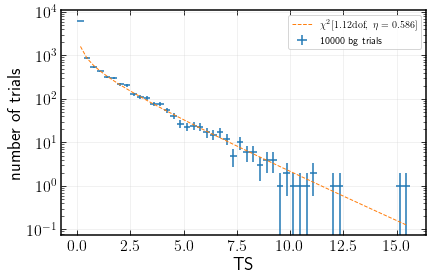

In [9]:
fig, ax = plt.subplots()

# csky uses histlite all over the place for PDF management
# the background distribution fit integrates with histlite as well
h = bg.get_hist(bins=50)
hl.plot1d(ax, h, crosses=True,
          label='{} bg trials'.format(bg.n_total))

# compare with the chi2 fit:
x = h.centers[0]
norm = h.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
            label=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

# always label your plots, folks
ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.legend()
plt.tight_layout()

In [10]:
with time('ps sensitivity'):
    sens = tr.find_n_sig(
        # ts, threshold
        bg.median(),
        # beta, fraction of trials which should exceed the threshold
        0.9,
        # n_inj step size for initial scan
        n_sig_step=5,
        # this many trials at a time
        batch_size=500,
        # tolerance, as estimated relative error
        tol=.05
    )

Start time: 2020-07-15 17:59:37.891163
Using 5 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.056...
  n_sig = 5.000 ... frac = 0.88000
  n_sig = 10.000 ... frac = 0.98000
* Generating batches of 500 trials...
n_trials | n_inj    0.00    4.00    8.00   12.00   16.00   20.00  |  n_sig(relative error)
500      |         47.6%   85.4%   96.4%   99.4%   99.6%  100.0%  |      5.205 (+/-  5.5%) [spline]
1000     |         50.5%   86.6%   96.8%   99.4%   99.7%  100.0%  |      4.929 (+/-  3.7%) [spline]
End time: 2020-07-15 18:00:09.756933
Elapsed time: 0:00:31.865770

0:00:31.867168 elapsed.


In [11]:
with time('ps discovery potential'):
    disc = tr.find_n_sig(bg.isf_nsigma(5), 0.5, n_sig_step=5, batch_size=500, tol=.05)

Start time: 2020-07-15 18:00:09.768960
Using 5 cores.
* Starting initial scan for 50% of 50 trials with TS >= 26.587...
  n_sig = 5.000 ... frac = 0.00000
  n_sig = 10.000 ... frac = 0.00000
  n_sig = 15.000 ... frac = 0.20000
  n_sig = 20.000 ... frac = 0.44000
  n_sig = 25.000 ... frac = 0.74000
* Generating batches of 500 trials...
n_trials | n_inj    0.00   10.00   20.00   30.00   40.00   50.00  |  n_sig(relative error)
500      |          0.0%    6.4%   49.6%   91.8%   99.2%   99.8%  |     20.093 (+/-  2.5%) [spline]
End time: 2020-07-15 18:00:28.338372
Elapsed time: 0:00:18.569412

0:00:18.572763 elapsed.


In [12]:
print(sens['n_sig'], disc['n_sig'])

4.928740107971437 20.09311396392415


In [13]:
fmt = '{:.3e}  TeV/cm2/s @ 100 TeV'
# either the number of events or the whole dict will work
print(fmt.format(tr.to_E2dNdE(sens, E0=100, unit=1e3)))
print(fmt.format(tr.to_E2dNdE(disc['n_sig'], E0=100, unit=1e3)))

4.875e-12  TeV/cm2/s @ 100 TeV
1.987e-11  TeV/cm2/s @ 100 TeV


In [14]:
n_sigs = np.r_[:101:10]
with time('ps fit bias trials'):
    trials = [tr.get_many_fits(500, n_sig=n_sig, logging=False, seed=n_sig) for n_sig in n_sigs]


0:00:30.230758 elapsed.


In [15]:
for (n_sig, t) in zip(n_sigs, trials):
    t['ntrue'] = np.repeat(n_sig, len(t))

In [16]:
allt = cy.utils.Arrays.concatenate(trials)
allt

Arrays(5500 items | columns: gamma, ns, ntrue, ts)

In [25]:
?h.contain_projectct

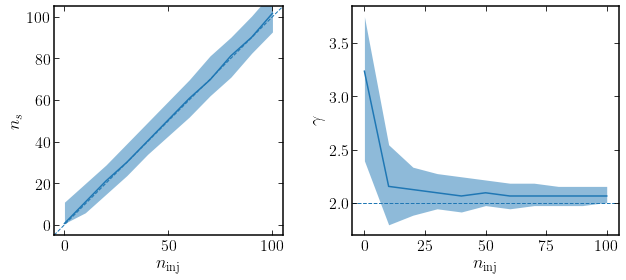

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))

dns = np.mean(np.diff(n_sigs))
ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
expect_gamma = tr.sig_injs[0].flux[0].gamma

ax = axs[0]
h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')

lim = ns_bins[[0, -1]]
ax.set_xlim(ax.set_ylim(lim))
ax.plot(lim, lim, **expect_kw)
ax.set_aspect('equal')


ax = axs[1]
h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')
ax.axhline(expect_gamma, **expect_kw)
ax.set_xlim(axs[0].get_xlim())

for ax in axs:
    ax.set_xlabel(r'$n_\mathrm{inj}$')
    ax.grid()
axs[0].set_ylabel(r'$n_s$')
axs[1].set_ylabel(r'$\gamma$')

fig.set_facecolor('w')
plt.tight_layout()

In [18]:
result = ts, ns, gamma = tr.get_one_fit(TRUTH=True)
print(result)

[9.143492682998701, 32.296588674993224, 2.99528081900467]


In [19]:
print(tr.format_result(tr.get_one_fit(TRUTH=True)))

TS                  9.143492682998701
ns                  32.296588674993224
gamma               2.99528081900467


In [20]:
tr.get_one_fit(TRUTH=True, flat=False)

(9.143492682998701, {'gamma': 2.99528081900467, 'ns': 32.296588674993224})

In [21]:
tr.get_one_fit(TRUTH=True, _full_output=True)

(9.143492682998701,
 {'gamma': 2.99528081900467, 'ns': 32.296588674993224},
 {},
 {'_full_output': True,
  '_ns_min': 0,
  '_ts_min': 0,
  '_ns_tol': 0.0001,
  '_taylor_tol': 0.001,
  '_fit_null': False,
  '_fmin_method': 'l_bfgs_b',
  '_fmin_factr': 1000000000.0,
  '_fmin_epsilon': 1e-08,
  '_seed_with_prior': True,
  '_seed_with_null': False,
  '_log_params': [],
  '_masks': None},
 {'grad': array([1.2434498e-06]),
  'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 10,
  'nit': 3,
  'warnflag': 0})

In [22]:
tr.get_one_fit(TRUTH=True, flat=False, gamma=[1.5, 2, 2.5])

(6.5191821804467605, {'gamma': 2.5, 'ns': 16.26252619566328})

In [23]:
print('p = {:.2e} ({:.2f} sigma)'.format(bg.sf(ts), bg.sf_nsigma(ts)))

p = 2.08e-03 (2.87 sigma)
